# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# Описание данных

<div> Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
<br> сalls — количество звонков,
<br> minutes — суммарная длительность звонков в минутах,
<br> messages — количество sms-сообщений,
<br> mb_used — израсходованный интернет-трафик в Мб,
<br> is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0). </div>

# Цель исследования

📌 Построить модель с максимально большим значением accuracy (минимум 0.75) для задачи классификации, которая выберет подходящий тариф. 

## Откройте и изучите файл

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


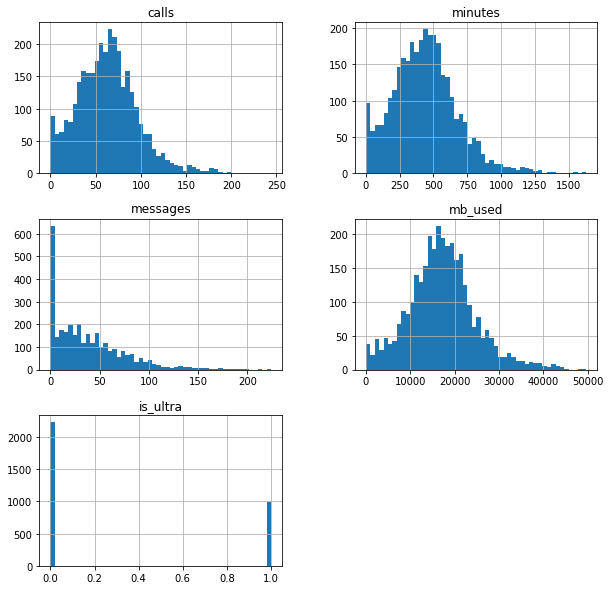

In [3]:
display(df.head(10))
df.info()
df.hist(bins=50, figsize=(10, 10));

### ✅ Вывод:
* Датасет содержит 3214 строк и 5 колонок
* Целевым признаком будет столбец **is_ultra**
* Тариф «Смарт» используется в два раза чаще, чем «Ультра»

## Разбейте данные на выборки

* Целевой признак является категориальным - тариф либо «Смарт», либо «Ультра», поэтому будем применять способы бинарной классификации: решающее дерево, случайный лес и логистическая регрессия
* Разделим датасет в соотношении 3:1:1
* Определим признаки и целевой признак для тренировочной и валидационной выборки

In [4]:
# разбиваем датасет на тренировочную и отдельную выборку в соотношении 60% / 40% 
df_train, df_forty_percent = train_test_split(df, test_size=0.4, random_state=12345)

# разбиваем получившуюся выше выборку на валидационную и тестовую по 20% на каждую
df_valid, df_test = train_test_split(df_forty_percent, test_size=0.5, random_state=12345)

In [5]:
# проверим, что ничего не потеряли
df.shape[0] == df_train.shape[0] + df_valid.shape[0] + df_test.shape[0]

True

In [6]:
# извлекаем признаки и целевой признак для тренировочной выборки
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra'] 

# извлекаем признаки и целевой признак для валидационной выборки
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra'] 

### ✅ Вывод:
* Датасет разделен на необходимые выборки

## Исследуйте модели

### Дерево решений

In [7]:
best_model_tree = None
best_result = 0
best_depth = 0

for depth in range(1, 11):
# обучаем модели с глубиной дерева от 1 до 15
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
# получаем предсказания каждой модели
    predictions = model_tree.predict(features_valid)
# считаем долю правильных ответов каждой модели
    result = accuracy_score(target_valid, predictions)
# если текущая доля правильных ответов больше сохраненной в best_result, то перезаписать переменные
# с моделью, долей правильных ответов и глубиной на текущие
    if result > best_result:
        best_model_tree = model_tree
        best_result = result
        best_depth = depth
        
print("Accuracy лучшей модели:", best_result)
print("max_depth лучшей модели:", best_depth)

Accuracy лучшей модели: 0.7853810264385692
max_depth лучшей модели: 3


В алгоритме решающего дерева получаем максимальную точность 79% при глубине дерева 3

### Случайный лес

In [8]:
%%time

best_model_forest = None
best_result = 0
best_est = 0
best_depth = 0 
best_leaf = 0

for est in range(1, 16, 2):
    for depth in range(1, 11):
            for leaf in range(2, 11):
                # обучаем модели с количеством деревьев от 1 до 15
                # с глубиной дерева от 2 до 10
                # и с минимальным числом объектов в листьях от 2 до 10
                model_forest = RandomForestClassifier(random_state=12345,
                                                      n_estimators=est,
                                                      max_depth=depth,
                                                      min_samples_leaf=leaf)
                model_forest.fit(features_train, target_train)
                # считаем долю правильных ответов каждой модели
                result = model_forest.score(features_valid, target_valid)
# если текущая доля правильных ответов больше сохраненной в best_result, то перезаписать переменные
# с моделью, долей правильных ответов, количеством деревьев, глубиной деревьев и минимальным числом объектов
# в листьях на текущие
                if result > best_result:
                    best_model_forest = model_forest
                    best_result = result
                    best_est = est
                    best_depth = depth
                    best_leaf = leaf
                    
print("Accuracy лучшей модели:", best_result)
print("n_estimators лучшей модели:", best_est)
print("max_depth лучшей модели:", best_depth)
print("min_samples_leaf лучшей модели:", best_leaf)

Accuracy лучшей модели: 0.807153965785381
n_estimators лучшей модели: 13
max_depth лучшей модели: 7
min_samples_leaf лучшей модели: 9
CPU times: user 15.4 s, sys: 125 ms, total: 15.6 s
Wall time: 15.6 s


В алгоритме случайного леса получаем максимальную точность 81% при 13 деревьях, с глубиной дерева 7 и минимальным числом объектов в листьях 9

### Логистическая регрессия

In [9]:
model_logistic_regression = LogisticRegression(random_state=12345)
model_logistic_regression.fit(features_train, target_train)
result = model_logistic_regression.score(features_valid, target_valid)
print("Accuracy модели:", result)

Accuracy модели: 0.7107309486780715


В алгоритме логистической регрессии получаем максимальную точность 71%

### ✅ Вывод:
* Хуже всего показала точность логистическая регрессия. Скорее всего она подходит для более объемных данных
* Самым точным алгоритмом для этих данных оказался случайный лес с 81% точностью
* Дерево решений с глубиной 3 тоже дает неплохую точность - 79%

## Проверьте модель на тестовой выборке

Теперь проверим модель на тестовой выборке

In [10]:
# извлекаем признаки и целевой признак для тестовой выборки
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra'] 

In [15]:
predictions_test_forest = best_model_forest.predict(features_test)
result_test_forest = model_forest.score(features_test, target_test)
result_test_forest

0.7978227060653188

### ✅ Вывод:
* Точность на тестовой выборке у случайного леса, получается 80%

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75


## Общий вывод

<div><br>🔹В ходе исследования мы проделали следующую работу:
<br>1. При изучении файла определили, что целевой признак is_ultra является категориальным - тариф либо «Смарт», либо «Ультра», поэтому в проекте применяются способы бинарной классификации: решающее дерево, случайный лес и логистическая регрессия
<br>2. Для инициализации моделей и их обучения разбили датасет на три выборки: тренировочную, валидационную и тестовую в пропорциях 3:1:1 - 60% / 20% / 20%
<br>3. Для построения модели с максимально большим значением accuracy были использованы следующие алгоритмы: решающее дерево, случайный лес и логистическая регрессия    
<br>
<br>📌 Оператору мобильной связи «Мегалайн» для рекомендательной системы тарифов стоит выбрать модель случайного леса, которая показала себя лучше остальных в ходе обучения и тестирования</div>